In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Embedding, Dense, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data=pd.read_csv("/content/drive/My Drive/ML Project/Reviews.csv",nrows=150000)
data.drop_duplicates(subset = ['Text'], inplace = True)
data.dropna(axis = 0, inplace = True)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
def cleaner(text, remove_stopwords=True):
  """removes url's, nltk's stopwords and anything which is not an alphabet"""
  
  stop_words = set(stopwords.words('english'))
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text.lower(), flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = contractions.fix(text, slang=False)
  if remove_stopwords:
    text = ' '.join([word for word in text.split() if word not in stop_words]).strip()
  return text

In [ ]:
!pip install contractions

In [ ]:
import contractions
from time import time
from math import ceil

t1 = time()
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(cleaner(t))

t2 = time()
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(cleaner(t, remove_stopwords = False))

t3 = time()
print('Text cleaned in {} sec, and Summary in {} sec'.format(ceil(t2-t1), ceil(t3-t2)))

data = pd.DataFrame({
    'text'    :   cleaned_text,
    'summary' :   cleaned_summary})

data.replace('', np.nan, inplace = True)
data.dropna(axis = 0, inplace = True)

Text cleaned in 5 sec, and Summary in 4 sec


In [ ]:
data.reset_index(inplace=True, drop=True)

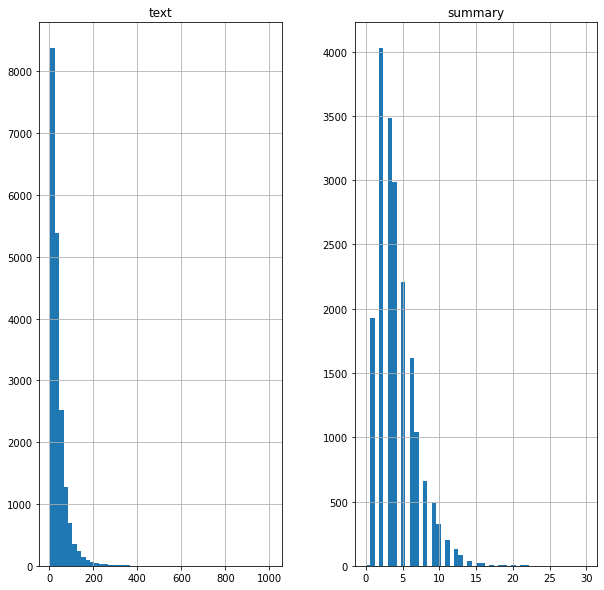

In [ ]:
text_word_count    = []
summary_word_count = []

for i in data['text']:
      text_word_count.append(len(i.split()))

for i in data['summary']:
      summary_word_count.append(len(i.split()))

visualize = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
visualize.hist(bins = 50)
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [ ]:
cnt = 0
for i in range(data.shape[0]):
  if len(data['text'][i].split()) <= 60 and len(data['summary'][i].split()) <= 10:
    cnt += 1
print(cnt)

15588


In [ ]:
_MAX_SUMMARY_LEN = 10
_MAX_TEXT_LEN    = 60
# Declaring the important variables here, which will be used later down the notebook

_NROWS           =   100000
_TEXT_PADDING    =   'post'
_EMBEDDING_DIM   =   500
_ENCODER_DIM     =   300
_DECODER_DIM     =   600
_BATCH_SIZE      =   64
_EPOCHS          =   40

In [ ]:

def prepare(dataset):
  global _MAX_SUMMARY_LEN, _MAX_TEXT_LEN
  newtext    =  []
  newsummary =  []
  
  for i in range(len(dataset['text'])):
    if len(dataset['text'][i].split()) <= _MAX_TEXT_LEN and len(dataset['summary'][i].split()) <= _MAX_SUMMARY_LEN:
      newtext.append(dataset['text'][i])
      newsummary.append(dataset['summary'][i])

  dataset = pd.DataFrame({'text'    : newtext,
                          'summary' : newsummary})
  dataset['summary'] = dataset['summary'].apply(lambda row : 'stok ' + row + ' etok')
  dataset.reset_index(drop=True, inplace=True)
  return dataset

In [ ]:
df = prepare(data)

In [ ]:

df.head()

,text,summary
0,bought several vitality canned dog food produc...,stok good quality dog food etok
1,product arrived labeled jumbo salted peanuts p...,stok not as advertised etok
2,confection around centuries light pillowy citr...,stok delight says it all etok
3,looking secret ingredient robitussin believe f...,stok cough medicine etok
4,great taffy great price wide assortment yummy ...,stok great taffy etok


In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=42)

In [ ]:
# preparing 'text' for model training and validation
tok_x  = Tokenizer()
tok_x.fit_on_texts(list(x_tr))
x_tr    =  pad_sequences(tok_x.texts_to_sequences(x_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
x_val   =  pad_sequences(tok_x.texts_to_sequences(x_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_x =  len(tok_x.word_counts) + 1

In [ ]:
vocab_x

17107

In [ ]:
# preparing 'summary' for model training and validation
tok_y  = Tokenizer()
tok_y.fit_on_texts(list(y_tr))
y_tr    =  pad_sequences(tok_y.texts_to_sequences(y_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
y_val   =  pad_sequences(tok_y.texts_to_sequences(y_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_y =  len(tok_y.word_counts) + 1

In [ ]:
vocab_y

5180

In [ ]:
tok_y.word_counts['stok'], len(y_tr)

(14029, 14029)

In [ ]:
index_to_word_text    =  tok_x.index_word
index_to_word_summary =  tok_y.index_word
word_to_index_summary =  tok_y.word_index

In [ ]:
# Encoder
encoder_input  =  Input(shape=(_MAX_TEXT_LEN,), name='Encoder_input')
encoder_embed  =  Embedding(vocab_x, _EMBEDDING_DIM, trainable=True, name='Encoder_embedding')(encoder_input)
encoder        =  Bidirectional(LSTM(_ENCODER_DIM, 
                                     return_sequences=True,
                                     return_state=True,
                                     dropout=0.4, recurrent_dropout=0.4), name='Encoder_layer')
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder(encoder_embed)
state_h        =  Concatenate()([forward_h, backward_h])
state_c        =  Concatenate()([forward_c, backward_c])

# Decoder
decoder_input        =  Input(shape=(None,), name='Decoder_input')
decoder_embed_layer  =  Embedding(vocab_y, _EMBEDDING_DIM, trainable=True, name='Decoder_embedding')
decoder_embed        =  decoder_embed_layer(decoder_input)
decoder              =  LSTM(_DECODER_DIM,
                             return_sequences=True,
                             return_state=True,
                             dropout=0.4, recurrent_dropout=0.3, name='Decoder_layer')
decoder_output, decoder_state_h, decoder_state_c = decoder(decoder_embed,initial_state=[state_h, state_c])

# Attention layer
attention_layer =  Attention(name='Attention_layer')
attention_out   =  attention_layer([decoder_output, encoder_output])

# Concat attention layer's output and decoder's output
concat_layer    =  Concatenate(axis=-1, name='Concat_layer')([decoder_output, attention_out])

# Dense layer
decoder_dense   =  TimeDistributed(Dense(vocab_y, activation='softmax'))
decoder_output  =  decoder_dense(concat_layer)

# Model 
model           =  Model([encoder_input, decoder_input], decoder_output, name='Model')

model.summary()

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 60)]         0                                            
__________________________________________________________________________________________________
Encoder_embedding (Embedding)   (None, 60, 500)      8553500     Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_layer (Bidirectional)   [(None, 60, 600), (N 1922400     Encoder_embedding[0][0]          
______________________________________________________________________________________________

In [ ]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

stopearly =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
X         =  [x_tr,y_tr[:,:-1]]
y         =  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:]
VAL_X     =  [x_val,y_val[:,:-1]]
VAL_y     =  y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
history   =  model.fit(X, y, epochs=10, callbacks=[stopearly], batch_size=_BATCH_SIZE, validation_data=(VAL_X, VAL_y))

Epoch 1/10
220/220 [==============================] - 1947s 9s/step - loss: 0.6198 - val_loss: 0.4049
Epoch 2/10
220/220 [==============================] - 1969s 9s/step - loss: 0.4203 - val_loss: 0.3932
Epoch 3/10
220/220 [==============================] - 1970s 9s/step - loss: 0.4033 - val_loss: 0.3803
Epoch 4/10
220/220 [==============================] - 1974s 9s/step - loss: 0.3802 - val_loss: 0.3632
Epoch 5/10
220/220 [==============================] - 1968s 9s/step - loss: 0.3543 - val_loss: 0.3498
Epoch 6/10
220/220 [==============================] - 1979s 9s/step - loss: 0.3292 - val_loss: 0.3428
Epoch 7/10
220/220 [==============================] - 1967s 9s/step - loss: 0.3044 - val_loss: 0.3397
Epoch 8/10
220/220 [==============================] - 1927s 9s/step - loss: 0.2792 - val_loss: 0.3388
Epoch 9/10
220/220 [==============================] - 1920s 9s/step - loss: 0.2530 - val_loss: 0.3412
Epoch 10/10
220/220 [==============================] - 1916s 9s/step - loss: 0.226

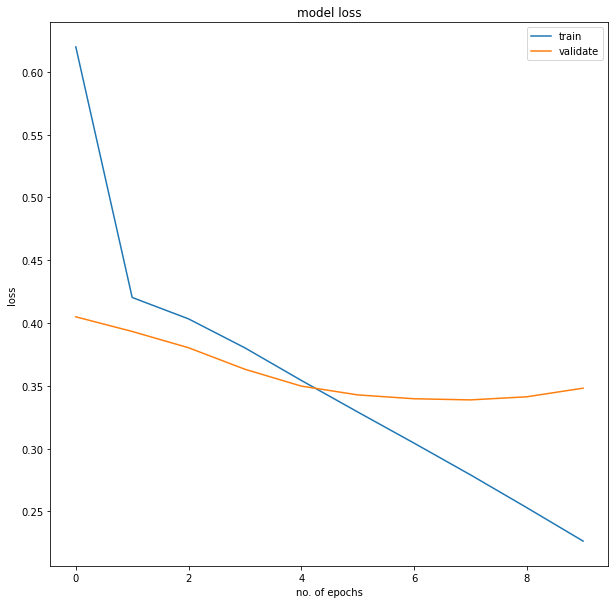

In [ ]:
# For loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('no. of epochs')
plt.ylabel('loss')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
_MODEL_NAME = 'model_3'
model.save('/content/drive/My Drive/ML Project/model3.h5')

In [ ]:
encoder_model = Model(inputs  = encoder_input,
                outputs = [encoder_output, state_h, state_c])

# For storing decoder's previous states which will act as our encoder here
decoder_previous_state_h = Input(shape=(_DECODER_DIM,))
decoder_previous_state_c = Input(shape=(_DECODER_DIM,))
decoder_previous_output  = Input(shape=(_MAX_TEXT_LEN, _DECODER_DIM))

# This new decoder will take the 'previous decoder' i.e, our encoder's output
decoder_embed_new = decoder_embed_layer(decoder_input)
decoder_output_new, state_h_new, state_c_new = decoder(decoder_embed_new,
                                                       initial_state = [decoder_previous_state_h, decoder_previous_state_c])

# Attention layer & concat layer for the new decoder and encoder
attention_out_new    =  attention_layer([decoder_output_new, decoder_previous_output])
concat_layer_final   =  Concatenate(axis=-1)([decoder_output_new, attention_out_new])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_output_final =  decoder_dense(concat_layer_final)

# Final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_previous_output, decoder_previous_state_h, decoder_previous_state_c],
    [decoder_output_final] + [state_h_new, state_c_new])

In [ ]:
# Summarizes an input sequence to the final sequence by making the encoder-decoder model 
# predict 1 word at a time

def summarizer(input_seq):
    encoder_out, encoder_h, encoder_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = word_to_index_summary['stok']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encoder_out, encoder_h, encoder_c])
        # Greedy decoder
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = index_to_word_summary[sampled_token_index]
        
        if sampled_token != 'etok':
            decoded_sentence += sampled_token + ' '

        if sampled_token == 'etok' or len(decoded_sentence.split()) >= (_MAX_SUMMARY_LEN-1):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        encoder_h, encoder_c = h, c

    return decoded_sentence

In [ ]:
def sequence_to_summary(input_seq):
    s = ''
    for i in input_seq:
        if i != 0 and i != word_to_index_summary['stok'] and i != word_to_index_summary['etok']:
            s += index_to_word_summary[i] + ' '
    return s

def sequence_to_text(input_seq):
    s = ''
    for i in input_seq:
        if i != 0:
            s += index_to_word_text[i] + ' '
    return s

In [ ]:
for i in range(5):
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",sequence_to_summary(y_tr[i]))
    print("Predicted summary:",summarizer(x_tr[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: coffee great cheaper bed bath beyond coupon taxes added 
Original summary: cheaper at bbb with coupon 
Predicted summary: great price 


Review: rarely eat anything whole wheat pasta every eat treat almost good pastas ate italy make sure cook 
Original summary: reminds me of italy 
Predicted summary: my son loves these 


Review: use loose tea time regular loose tea become hard find local grocery stores subscription great 
Original summary: love this service 
Predicted summary: rishi tea loose leaf tea bags 


Review: love soy nuts especially garlic onion blend perfect taking party snacking go happy every product truson 
Original summary: organic fresh crunchy 
Predicted summary: delicious 


Review: found product discounted good price slickdeals net br br first time drinking stuff since bought blown away awesome taste first time trying something nestle brand cocoa times ordered cocoa cafe br br nice blend mocoa cocoa taste sweet like used nestle br br definitely giving thumbs 

In [ ]:
for i in range(5):
    print("Review:",sequence_to_text(x_val[i]))
    print("Original summary:",sequence_to_summary(y_val[i]))
    print("Predicted summary:",summarizer(x_val[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: looking great grain free alternative beef chicken two girls loved used put kongs put dry food seal end wet food put freezer dinner would become challenge con food pricey wellness products could probably get results looking grain free food something like taste wild gone cost 
Original summary: great grain free food 
Predicted summary: my cats love this food 


Review: eaten alot different kinds walnuts never found better emerald dry roasted walnuts love senior citizen would recommend everyone good 
Original summary: walnuts 
Predicted summary: great product 


Review: high quality tea first open bergamot scent floor strong bad way beautifully citrus filled tea leaves seen packaged tea specialty tea store mean fragments breakage nice clean full leaves br br brews nice looks smooth flavor bitterness br br recommend giving try looking new tea brand disappoint 
Original summary: excellent aromatic and smooth 
Predicted summary: my favorite tea 


Review: bought sweet potato fish die

In [ ]:
import re
import os
import pickle
import logging
import numpy as np
import pandas as pd
import contractions
from nltk.corpus import stopwords
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)


class Summarizer:

  def __init__(self):
    self.dir_path = '/content/gdrive/My Drive/Colab Notebooks/Summarization/summarization v2'
    self._MAX_TEXT_LEN    =  60
    self._MAX_SUMMARY_LEN =  10
    self._TEXT_PADDING    =  'post'
    self.encoder_model = encoder_model
    self.decoder_model = decoder_model
    self.index_to_word_text, self.index_to_word_summary, self.word_to_index_summary = index_to_word_text, index_to_word_summary, word_to_index_summary
    self.tok_x = tok_x
  
  def summarize(self, sent):
    """wrapper function to test the model"""

    sent = self.cleaner(sent, remove_stopwords=True)
    if len(sent.split()) > self._MAX_TEXT_LEN:
      return "make your sentence length less than {} words".format(self._MAX_TEXT_LEN)

    seq = self.tok_x.texts_to_sequences(sent.split())
    seq = [[item for sublist in seq for item in sublist]]
    seq = pad_sequences(seq, maxlen=self._MAX_TEXT_LEN, padding=self._TEXT_PADDING)
    return self.seq2seq_model(seq.reshape(1, self._MAX_TEXT_LEN))


  def cleaner(self, text, remove_stopwords=True):
    """removes url's, nltk's stopwords and anything which is not an alphabet"""

    stop_words = set(stopwords.words('english'))
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text.lower(), flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = contractions.fix(text, slang=False)
    if remove_stopwords:
      text = ' '.join([word for word in text.split() if word not in stop_words]).strip()
      
    return text
  
  def seq2seq_model(self, input_seq):
    """summarizes the input text given and returns the summarized string"""

    encoder_out, encoder_h, encoder_c = self.encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = self.word_to_index_summary['stok']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
      output_tokens, h, c = self.decoder_model.predict([target_seq] + [encoder_out, encoder_h, encoder_c])
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = self.index_to_word_summary[sampled_token_index]
      
      if sampled_token != 'etok':
        decoded_sentence += sampled_token + ' '
        
      if sampled_token == 'etok' or len(decoded_sentence.split()) >= (self._MAX_SUMMARY_LEN-1):
        stop_condition = True

      target_seq = np.zeros((1,1))
      target_seq[0, 0] = sampled_token_index
      encoder_h, encoder_c = h, c

    return decoded_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from rouge import Rouge

scorer = Rouge()

In [ ]:
!pip install Rouge

In [ ]:

# loading our model
model1 = Summarizer()

In [ ]:
def tryit(sent):
  """wrapper function to test the model"""

  sent = cleaner(sent, remove_stopwords=True)
  if len(sent.split()) > _MAX_TEXT_LEN:
    return "make your sentence length less than {} words".format(_MAX_TEXT_LEN)

  seq = tok_x.texts_to_sequences(sent.split())
  seq = [[item for sublist in seq for item in sublist]]
  seq = pad_sequences(seq, maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
  return summarizer(seq.reshape(1,_MAX_TEXT_LEN))

In [ ]:
text = 'We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented. \
The waiters were attentive and service overall was good. The restaurant looked to have been recently decorated. \
Overall a good meal and great value we will certainly be going back.'

real_summary = 'tried megna good food attentive waiters'

In [ ]:
tryit(text)

'great product '

In [ ]:

text1 = text.split('.')
for l in text1:
  if len(l) > 0:
    print('text :', l.strip())
    print('predict:', tryit(l))
    print('\n')

text : We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented
predict: great product 


text : The waiters were attentive and service overall was good
predict: good product 


text : The restaurant looked to have been recently decorated
predict: green mountain breakfast blend 


text : Overall a good meal and great value we will certainly be going back
predict: good value 




In [ ]:
tryit('the food was terribly good')

'good stuff '

In [ ]:
tryit('the food was terrible')

'good stuff '

In [ ]:
tryit('the food was bad at first but finally it turned out to be otherwise')

'not bad '

In [ ]:
tryit('I love maggi but couldn\'t find any')

'great product '

In [ ]:

tryit('well the food was not that bad but certainly can be improved')

'good quality '

In [ ]:
# storing all the rouge scores
rouge_1 = {'f':[], 'p':[], 'r':[]}
rouge_2 = {'f':[], 'p':[], 'r':[]}
rouge_l = {'f':[], 'p':[], 'r':[]}

In [ ]:
for i in range(df.shape[0]):
  text = df['text'][i]
  reference = ' '.join(df['summary'][i].split()[1:-1])
  if len(reference) == 0:
    continue
  hypothesis = model1.summarize(text)
  scores = scorer.get_scores(hypothesis, reference)[0]
  one, two, l = scores['rouge-1'], scores['rouge-2'], scores['rouge-l']
  for p, q in one.items():
    rouge_1[p].append(q)
  for p, q in two.items():
    rouge_2[p].append(q)
  for p, q in l.items():
    rouge_l[p].append(q)

In [ ]:

np.mean(rouge_1['f']), np.mean(rouge_1['p']), np.mean(rouge_1['r'])

(0.22793531496743133, 0.25894097222222223, 0.22717427248677247)

In [ ]:
np.mean(rouge_2['f']), np.mean(rouge_2['p']), np.mean(rouge_2['r'])

(0.07575231423031122, 0.09010416666666667, 0.06956845238095237)

In [ ]:
np.mean(rouge_l['f']), np.mean(rouge_l['p']), np.mean(rouge_l['r'])

(0.22896171911236507, 0.25972222222222224, 0.2273602843915344)

In [ ]:
arr1=list()
arr1.append(["Rouge 1",np.mean(rouge_1['f']), np.mean(rouge_1['p']), np.mean(rouge_1['r'])])
arr1.append(["Rouge 2",np.mean(rouge_2['f']), np.mean(rouge_2['p']), np.mean(rouge_2['r'])])
arr1.append(["Rouge l",np.mean(rouge_l['f']), np.mean(rouge_l['p']), np.mean(rouge_l['r'])])

In [ ]:
Rouge=["Rouge 1","Rouge 2","Rouge l"]

In [ ]:
arr1

[['Rouge 1', 0.22793531496743133, 0.25894097222222223, 0.22717427248677247],
 ['Rouge 2', 0.07575231423031122, 0.09010416666666667, 0.06956845238095237],
 ['Rouge l', 0.22896171911236507, 0.25972222222222224, 0.2273602843915344]]

In [ ]:
df_final=pd.DataFrame(arr1,columns=["Rouge","f","p","r"],)

In [ ]:
df_final

,Rouge,f,p,r
0,Rouge 1,0.227935,0.258941,0.227174
1,Rouge 2,0.075752,0.090104,0.069568
2,Rouge l,0.228962,0.259722,0.227360
